In [2]:
s%run setup_PS_data_multi.ipynb
import pandas as pd
import math, cmath
from tqdm import tqdm
print('------------------------------------')
print(f'{len(sessions)} sessions are loaded')

Now loading mouse RL070, run 22
Now loading mouse RL070, run 23
Now loading mouse RL070, run 24
Now loading mouse RL070, run 27
Now loading mouse RL070, run 28
microcontroller trial starts occur on average -70.14 ms from galvo trial starts
1 / 625 cells filtered
photo stim occurences: {0: 127, 1: 140, 2: 119}
Occurence table:
[[123.   4.]
 [119.  21.]
 [ 80.  39.]]
375 / 375 non nan trials identified
Numbers of PS cells: [  0   5  10  20  30  40  50 150]
succesfully loaded mouse RL070, run 28
Now loading mouse RL070, run 29
microcontroller trial starts occur on average nan ms from galvo trial starts
0 / 718 cells filtered
photo stim occurences: {0: 96, 1: 93, 2: 90}
Occurence table:
[[78. 18.]
 [46. 47.]
 [35. 55.]]
263 / 263 non nan trials identified
Numbers of PS cells: [  0   5  10  20  30  40  50 150]
succesfully loaded mouse RL070, run 29
Now loading mouse J047, run 7
Now loading mouse J048, run 15
Now loading mouse J048, run 16
Now loading mouse J048, run 18
Now loading mouse J04

# START

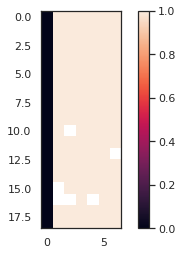

In [4]:


def beh_metric(sessions, metric='accuracy',
               stim_array=[0, 5, 10, 20, 30, 40, 50]):
    acc = np.zeros((len(sessions), len(stim_array)))
    for i_session, session in sessions.items():
        for i_stim, stim in enumerate(stim_array):
            trial_inds = np.where(session.trial_subsets == stim)[0]
            tp = np.sum(session.outcome[trial_inds] == 'hit')
            fp = np.sum(session.outcome[trial_inds] == 'fp')
            tn = np.sum(session.outcome[trial_inds] == 'cr')
            fn = np.sum(session.outcome[trial_inds] == 'miss')
            assert (tp + fp + tn + fn) == len(session.outcome[trial_inds])
            if metric == 'accuracy':
                acc[i_session, i_stim] = (tp + tn) / (tp + fp + tn + fn)
            elif metric == 'sensitivity':
                acc[i_session, i_stim] = tp / (tp + fp)
    return acc

plt.imshow(beh_metric(sessions=sessions, metric='sensitivity'))
plt.colorbar()

In [5]:
def fun_return_2d(data):  # possibly add fancy stuff
    return np.mean(data, 2)

def angle_vecs(v1, v2):
    assert v1.shape == v2.shape
    v1, v2 = np.squeeze(v1), np.squeeze(v2)
    tmp = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    rad = np.arccos(tmp)
    deg = rad * 360 / (2 * np.pi)
    return deg

def mean_angle(deg):
    return math.degrees(cmath.phase(sum([cmath.rect(1, math.radians(d)) for d in deg])/len(deg)))

def create_dict_pred(nl, train_proj, lt):
        dict_predictions_test = {x + '_test': np.array([]) for x in nl}  # make dicts to save
        dict_predictions_train = {x + '_train': np.array([]) for x in nl}
        if train_proj:
            for x in lt:
                dict_predictions_train[f'pred_{x}_train_proj'] = np.array([])
                dict_predictions_test[f'pred_{x}_test_proj'] = np.array([])
        if len(lt) == 2:
            dict_predictions_train['angle_decoders'] = np.array([])
        return dict_predictions_train, dict_predictions_test

# for ii in range(len(sessions)):
#     sessions[ii].shuffle_labels()


In [318]:
def train_test_all_sessions(sessions, trial_times_use=None, verbose=2, list_test = ['dec', 'stim'],
                            hitmiss_only=False, include_150 = False,
                            n_split = 4, include_autoreward=True, neurons_selection='all',
                            C_value=0.2, reg_type='l2', train_projected=False):
    if hitmiss_only:
        if verbose >= 1:
            print('Using hit/miss trials only.')
        if 'stim' in list_test:
            list_test.remove('stim')  # no point in estimating stim, because only PS
            
    name_list = ['autorewarded']  # names of details to save - whether autorewrd trial or not
    for nn in list_test:
        name_list.append('pred_' + nn)  # prediction
    for nn in ['dec', 'stim']:
        name_list.append('true_' + nn)  # ground truth
        
    mouse_list = np.unique([ss.mouse for _, ss in sessions.items()])
    df_prediction_train, df_prediction_test = dict(), dict()
    if verbose >= 2:
        print(mouse_list)
    for mouse in mouse_list:
        angle_decoders = np.zeros((len(sessions), n_split))
        dict_predictions_train, dict_predictions_test = create_dict_pred(nl=name_list, train_proj=train_projected, lt=list_test)
        for i_session, session in sessions.items():  # loop through sessions/runs and concatenate results (in dicts)
            if session.mouse == mouse:  # only evaluate current mouse
                if verbose >= 1:
                    print(f'Mouse {mouse}, Starting loop {i_session + 1}/{len(sessions)}')
                if trial_times_use is None:
                    trial_frames_use = session.filter_ps_array[(session.final_pre_gap_tp + 1):(session.final_pre_gap_tp + 6)]
                    print('WARNING: trial_times undefined so hard-coding them (to 5 post-stim frames)')
                else:
                    trial_frames_use = []
                    for tt in trial_times_use:
                        trial_frames_use.append(session.filter_ps_array[np.where(session.filter_ps_time == tt)[0][0]])  # this will throw an error if tt not in filter_ps_time
                    trial_frames_use = np.array(trial_frames_use)
                    assert len(trial_times_use) == len(trial_frames_use)
                    if verbose >= 2:
                        print(trial_times_use, trial_frames_use)

                ## Set neuron inds
                if neurons_selection == 'all':
                    neurons_include = np.arange(session.behaviour_trials.shape[0])
                elif neurons_selection == 's1':
                    neurons_include = session.s1_bool
                elif neurons_selection == 's2':
                    neurons_include = session.s2_bool
                if verbose >= 2:
                    print(f'n neurons: {np.sum(neurons_include)}/{len(neurons_include)}, {neurons_selection}')
                ## Set trial inds
                if include_150 is False:
                    trial_inds = np.where(session.photostim < 2)[0]
                else:
                    trial_inds = np.arange(len(session.photostim))

                if hitmiss_only:
                    hitmiss_trials = np.where(np.logical_or(session.outcome == 'hit', session.outcome == 'miss'))[0]
                    if verbose == 2:
                        print(f'Size hm {hitmiss_trials.size}, trial inds {trial_inds.size}')
                    trial_inds = np.intersect1d(trial_inds, hitmiss_trials)

                if include_autoreward is False:
                    ar_exclude = np.where(session.autorewarded == False)[0]
                    if verbose == 2:
                        print(f'{np.sum(session.autorewarded)} autorewarded trials found and excluded')
                    trial_inds = np.intersect1d(trial_inds, ar_exclude)

                if verbose == 2:
                    print(f'final size {trial_inds.size}')
                n_trials = len(trial_inds)
                if verbose == 2:
                    print(f'Total number of trials is {n_trials}. Number of splits is {n_split}')

                # Prepare data with selections
                data_use = session.behaviour_trials[neurons_include, :, :]
                data_use = data_use[:, :, trial_frames_use]
                data_use = data_use[:, trial_inds, :]
                data_use = fun_return_2d(data_use)
                stand_scale = sklearn.preprocessing.StandardScaler()
                data_use = stand_scale.fit_transform(data_use)
  
                sss = sklearn.model_selection.StratifiedKFold(n_splits=n_split)  # split into n_split data folds of trials
                if verbose == 2:
                    print(f'Number of licks: {np.sum(session.decision[trial_inds])}')
                    dict_outcomes = {x: np.sum(session.outcome[trial_inds] == x) for x in np.unique(session.outcome[trial_inds])}
                    print(f'Possible trial outcomes: {dict_outcomes}')
                    dict_n_ps = {x: np.sum(session.trial_subsets[trial_inds] == x) for x in np.unique(session.trial_subsets[trial_inds])}
                    print(f'Possible stimulations: {dict_n_ps}')
                               
                i_loop = 0
                for train_inds, test_inds in sss.split(X=np.zeros(n_trials), y=session.outcome[trial_inds]):  # loop through different train/test folds, concat results
                    train_data, test_data = data_use[:, train_inds], data_use[:, test_inds]
                    if i_loop == 0:
                        if verbose == 2:
                            print(f'Shape train data {train_data.shape}, test data {test_data.shape}')

                    ## Get labels and categories of trials
                    train_labels = {'stim': session.photostim[trial_inds[train_inds]],
                                    'dec': session.decision[trial_inds[train_inds]]}
                    test_labels = {'stim': session.photostim[trial_inds[test_inds]], 
                                   'dec': session.decision[trial_inds[test_inds]]}
                    if verbose == 2:
                        print(f' Number of test licks {np.sum(test_labels["dec"])}')
                    detailed_ps_labels = session.trial_subsets[trial_inds].astype('int')
                    autorewarded = session.autorewarded[trial_inds]
                    assert len(train_labels['dec']) == train_data.shape[1]
                    assert len(test_labels['stim']) == test_data.shape[1]

                    ## Train logistic regression model on train data
                    dec = {}
                    for x in list_test:
                        dec[x] = sklearn.linear_model.LogisticRegression(penalty=reg_type, C=C_value, class_weight='balanced').fit(
                                        X=train_data.transpose(), y=train_labels[x])

                    if len(list_test) == 2:
                        angle_decoders[i_session, i_loop] = angle_vecs(dec[list_test[0]].coef_, dec[list_test[1]].coef_)

                    if train_projected:  # project and re decode
                        dec_proj = {}
                        assert len(list_test) == 2  # hard coded that len==2 further on
                        for i_x, x in enumerate(list_test):
                            i_y = 1 - i_x
                            y = list_test[i_y]
                            assert x != y
                            enc_vector = dec[y].coef_ / np.linalg.norm(dec[y].coef_)
                            train_data_proj = enc_vector.copy() * train_data.transpose()
                            test_data_proj = enc_vector.copy() * test_data.transpose()
                            dec_proj[x] = sklearn.linear_model.LogisticRegression(penalty=reg_type, C=C_value, class_weight='balanced').fit(
                                            X=train_data_proj, y=train_labels[x])

                    ## Predict test data
                    pred_proba_train = {x: dec[x].predict_proba(X=train_data.transpose())[:, 1] for x in list_test}
                    pred_proba_test = {x: dec[x].predict_proba(X=test_data.transpose())[:, 1] for x in list_test}
                    if train_projected:
                        pred_proba_train_proj = {x: dec_proj[x].predict_proba(X=train_data_proj)[:, 1] for x in list_test}
                        pred_proba_test_proj = {x: dec_proj[x].predict_proba(X=test_data_proj)[:, 1] for x in list_test}

                    ## Save results
                    for x in list_test: 
                        dict_predictions_train[f'pred_{x}_train'] = np.concatenate((dict_predictions_train[f'pred_{x}_train'], pred_proba_train[x]))
                        dict_predictions_test[f'pred_{x}_test'] = np.concatenate((dict_predictions_test[f'pred_{x}_test'], pred_proba_test[x]))
                        if train_projected:
                            dict_predictions_train[f'pred_{x}_train_proj'] = np.concatenate((dict_predictions_train[f'pred_{x}_train_proj'], pred_proba_train_proj[x]))
                            dict_predictions_test[f'pred_{x}_test_proj'] = np.concatenate((dict_predictions_test[f'pred_{x}_test_proj'], pred_proba_test_proj[x]))
                    if len(list_test) == 2:
                        dict_predictions_train['angle_decoders'] = np.concatenate((dict_predictions_train['angle_decoders'], np.zeros_like(pred_proba_train[x]) + angle_decoders[i_session, i_loop]))
                    dict_predictions_train['true_stim_train'] = np.concatenate((dict_predictions_train['true_stim_train'], detailed_ps_labels[train_inds]))
                    dict_predictions_test['true_stim_test'] = np.concatenate((dict_predictions_test['true_stim_test'], detailed_ps_labels[test_inds]))
                    dict_predictions_train['autorewarded_train'] = np.concatenate((dict_predictions_train['autorewarded_train'], autorewarded[train_inds]))
                    dict_predictions_test['autorewarded_test'] = np.concatenate((dict_predictions_test['autorewarded_test'], autorewarded[test_inds]))
                    dict_predictions_train['true_dec_train'] = np.concatenate((dict_predictions_train['true_dec_train'], train_labels['dec']))
                    dict_predictions_test['true_dec_test'] = np.concatenate((dict_predictions_test['true_dec_test'], test_labels['dec']))
                    i_loop += 1
        if verbose == 2:
            print(f'length test: {len(dict_predictions_test["true_dec_test"])}')
        ## Put dictionary results into dataframes:
        df_prediction_train[mouse] = pd.DataFrame(dict_predictions_train)
        df_prediction_test[mouse] = pd.DataFrame(dict_predictions_test)
    return df_prediction_train, df_prediction_test
    
def plot_df_stats(df, xx, yy, hh, plot_line=True, xticklabels=None,
                  type_scatter='strip'):
    """Plot individual trials
    
    Parameters:
    -------------
        type_scatter: str, default='strip
            'strip' for stripplot, 'violin' for violin plot
    """
#     yy = yy + '_proj'
    if plot_line and hh is None:
        sns.pointplot(data=df, x=xx, y=yy, color='grey', ci='sd', label=None)
    elif plot_line and hh is not None:
        sns.pointplot(data=df, x=xx, y=yy, hue=hh, ci='sd', label=None)
    if type_scatter == 'strip':
        trial_plot_fun = sns.stripplot
    elif type_scatter == 'violin':
        trial_plot_fun = sns.violinplot
    elif type_scatter == 'swarm':
        trial_plot_fun = sns.swarmplot
    if hh is None:  
        tmp = trial_plot_fun(x=xx, y=yy, hue=hh, data=df, linewidth=1, label=None, color='grey')
    else:  
        tmp = trial_plot_fun(x=xx, y=yy, hue=hh, data=df, linewidth=1, label=None)
    if xticklabels is not None:
        tmp.set_xticklabels(xticklabels)

In [319]:
for _, ss in sessions.items():
    print(_, ss)

0 Mouse RL070, run 28
1 Mouse RL070, run 29
2 Mouse J048, run 27
3 Mouse J048, run 28
4 Mouse J048, run 29
5 Mouse J048, run 30
6 Mouse J048, run 32
7 Mouse J064, run 10
8 Mouse J064, run 11
9 Mouse J064, run 14
10 Mouse J063, run 8
11 Mouse J063, run 9
12 Mouse RL048, run 23
13 Mouse RL048, run 24
14 Mouse RL048, run 25
15 Mouse RL048, run 28
16 Mouse RL048, run 29
17 Mouse J065, run 10
18 Mouse J065, run 11


Mouse RL048, Starting loop 1/1
Accuracy PS: 0.5520492558400669
Accuracy lick: 0.5009223290271662


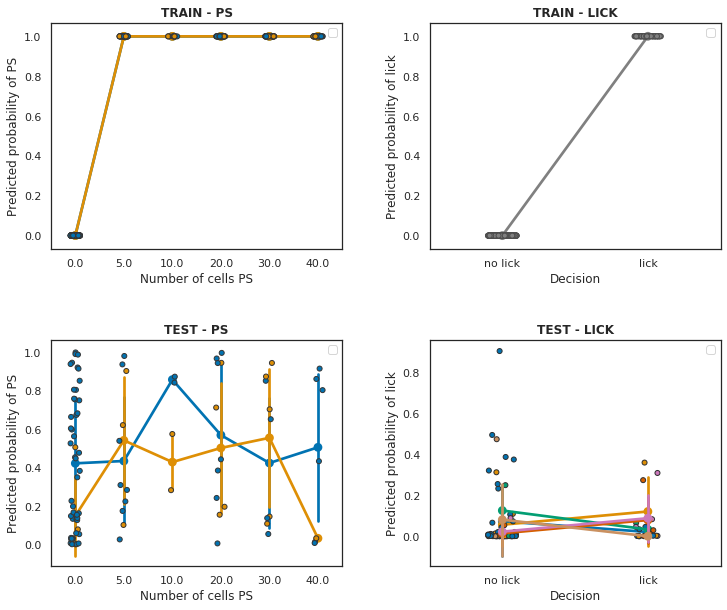

In [323]:
time_frame = -1
n_splits = 4
ss_dict = {0: sessions[12]}
df_prediction_train, df_prediction_test = train_test_all_sessions(sessions=ss_dict, verbose=1, n_split=n_splits,
                                              trial_times_use=np.array([time_frame]),
                                         hitmiss_only=False,# list_test=['dec', 'stim'],
                                         include_autoreward=True, neurons_selection='s1',
                                         C_value=50, train_projected=False)

plt.rcParams['figure.figsize'] = (12, 10)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
    
## NB: To not plot with hue, set hh=None
# for mouse in df_prediction_train.keys():
for mouse in [ss_dict[0].mouse]:
    if 'pred_stim_train' in df_prediction_train[mouse].columns:
        plt.subplot(221)
        plot_df_stats(df=df_prediction_train[mouse], xx='true_stim_train', yy='pred_stim_train', hh='true_dec_train')  # set hh=None or hh='dec_train'
        plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TRAIN - PS', weight='bold')
        plt.legend([])

        plt.subplot(223)
        plot_df_stats(df=df_prediction_test[mouse], xx='true_stim_test', yy='pred_stim_test', hh='true_dec_test')  # set hh=None or hh='dec_test'
        plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TEST - PS', weight='bold')
        plt.legend([])
        print(f'Accuracy PS: {class_av_mean_accuracy(binary_truth=(df_prediction_test[mouse]["true_stim_test"] > 0).astype("int"), estimate=df_prediction_test[mouse]["pred_stim_test"])[0]}')
        
    if 'pred_dec_train' in df_prediction_train[mouse].columns:  
        plt.subplot(222)
        plot_df_stats(df=df_prediction_train[mouse], xx='true_dec_train', yy='pred_dec_train', hh=None, xticklabels=['no lick', 'lick'])
        plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TRAIN - LICK', weight='bold')
        plt.legend('No lick', 'lick')

        plt.subplot(224)
        plot_df_stats(df=df_prediction_test[mouse], xx='true_dec_test', yy='pred_dec_test', hh='true_stim_test', xticklabels=['no lick', 'lick'], type_scatter='strip')
        plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TEST - LICK', weight='bold');
        plt.legend([])
        print(f'Accuracy lick: {class_av_mean_accuracy(binary_truth=df_prediction_test[mouse]["true_dec_test"], estimate=df_prediction_test[mouse]["pred_dec_test"])[0]}')
# plt.suptitle(f'(Logistic Regression) decoding performance for frame {time_frame}: \n{[str(sessions[x]) for x in range(len(sessions))]}\n' + 
# #              f'Left column shows Photostimulation (PS) decoding performance, right column shows lick decoding\n' +
#              f'Top row shows train data; bottom row shows test data, {n_splits} splits\n');

In [103]:
df_prediction_test[mouse]['true_stim_test'].max()

50.0

In [6]:
# mouse = 'J048'
# print(df_prediction_test[mouse][np.logical_and(df_prediction_test[mouse]['autorewarded_test'] == 1,
#                                                df_prediction_test[mouse]['true_stim_test'] > 0)]['pred_dec_test'].mean())

# print(df_prediction_test[mouse][np.logical_and(df_prediction_test[mouse]['autorewarded_test'] == 0,
#                                                df_prediction_test[mouse]['true_stim_test'] > 0)]['pred_dec_test'].mean())

# print(df_prediction_test[mouse][df_prediction_test[mouse]['true_stim_test'] > 0 ]['pred_dec_test'].mean())

## Dynamic coding:

In [394]:
## Some functions that can be used as accuracy assessment 
def prob_correct(binary_truth, estimate):    
    """Return probability of correct estimate, where bt = {0, 1} and est = (0, 1)"""
    prob = (binary_truth * estimate + (1 - binary_truth) * (1 - estimate))
    return prob

def mean_accuracy(binary_truth, estimate):
    """Mean accuracy (average over all trials)"""
    assert len(binary_truth) == len(estimate)
    pp = prob_correct(binary_truth=binary_truth, estimate=estimate)
    return np.mean(pp), np.std(pp)

def mean_accuracy_pred(binary_truth, estimate):
    """Mean accuracy with hard >0.5 threshold (average of all trials)"""
    round_est = np.round(estimate)
    return sklearn.metrics.accuracy_score(binary_truth, round_est), 0

def llh(binary_truth, estimate):
    """Log likelihood of all trials"""
    assert len(binary_truth) == len(estimate)
    pp = prob_correct(binary_truth=binary_truth, estimate=estimate)
    llh = np.mean(np.log(np.clip(pp, a_min=1e-3, a_max=1)))
    return llh, 0

def r2_acc(binary_truth, estimate):
    """R2, plainly averaged over all trials (not variance-weighted)"""
    return sklearn.metrics.r2_score(y_true=binary_truth, y_pred=estimate), 0
                  
def separability(binary_truth, estimate):
    """Measure difference between averages P(1) and P(0)."""
    av_pred_0 = np.mean(estimate[binary_truth == 0])
    av_pred_1 = np.mean(estimate[binary_truth == 1])
    sep = av_pred_1 - av_pred_0
    return sep, 0

def min_mean_accuracy(binary_truth, estimate):
    """Minimum of averages P(1) and P(0)"""
    mean_acc_true = np.mean(estimate[binary_truth == 1])
    mean_acc_false = 1 - np.mean(estimate[binary_truth == 0])
    return np.minimum(mean_acc_true, mean_acc_false), 0

def class_av_mean_accuracy(binary_truth, estimate):
    """Mean of averages P(1) and P(0)"""
    mean_acc_true = np.mean(estimate[binary_truth == 1])
    mean_acc_false = 1 - np.mean(estimate[binary_truth == 0])
    return 0.5 * (mean_acc_true + mean_acc_false), 0

## Main function to compute accuracy of decoders per time point
def compute_accuracy_time_array(sessions, time_array, average_fun=class_av_mean_accuracy, reg_type='l2',
                                region_list=['s1', 's2'], regularizer=0.02, projected_data=False):
    """Compute accuracy of decoders for all time steps in time_array, for all sessions (concatenated per mouse)"""
    mouse_list = np.unique([ss.mouse for _, ss in sessions.items()])
    stim_list = [0, 5, 10, 20, 30, 40, 50]  # hard coded!
    dec_list = [0, 1]  # hard_coded!! 
    mouse_s_list = []
    for mouse in mouse_list:
        for reg in region_list:
            mouse_s_list.append(mouse + '_' + reg)
    n_timepoints = len(time_array)

    lick_acc = {mouse: np.zeros((n_timepoints, 2)) for mouse in mouse_s_list} #mean, std
    lick_acc_split = {x: {mouse: np.zeros((n_timepoints, 2)) for mouse in mouse_s_list} for x in stim_list}  # split per ps conditoin
    lick_half = {mouse: np.zeros((n_timepoints, 2)) for mouse in mouse_s_list}  # naive with P=0.5 for 2 options (lick={0, 1})
    ps_acc = {mouse: np.zeros((n_timepoints, 2)) for mouse in mouse_s_list} 
    ps_acc_split = {x: {mouse: np.zeros((n_timepoints, 2)) for mouse in mouse_s_list} for x in dec_list}  # split per lick conditoin
    angle_dec = {mouse: np.zeros(n_timepoints) for mouse in mouse_s_list}
    for i_tp, tp in tqdm(enumerate(time_array)):  # time array IN SECONDS
        
        for reg in region_list:
            df_prediction_train, df_prediction_test = train_test_all_sessions(sessions=sessions, trial_times_use=np.array([tp]), 
                                                          verbose=0, hitmiss_only=False, include_150=False,
                                                          include_autoreward=True, C_value=regularizer, reg_type=reg_type,
                                                          train_projected=projected_data,
                                                          neurons_selection=reg)
            for mouse in df_prediction_train.keys():
                lick = df_prediction_test[mouse]['true_dec_test'].copy()
                ps = (df_prediction_test[mouse]['true_stim_test'] > 0).astype('int').copy()
                if projected_data is False:
                    pred_lick = df_prediction_test[mouse]['pred_dec_test'].copy()
                else:
                    pred_lick = df_prediction_test[mouse]['pred_dec_test_proj']  
                lick_half[mouse + '_' + reg][i_tp, :] = average_fun(binary_truth=lick, estimate=(np.zeros_like(lick) + 0.5))  # control for P=0.5
                lick_acc[mouse + '_' + reg][i_tp, :] = average_fun(binary_truth=lick, estimate=pred_lick)
#                 lick_acc[mouse + '_' + reg][i_tp, :] = 0
#                 for i_lick in np.unique(lick):
#                     lick_acc[mouse + '_' + reg][i_tp, :] += np.array(average_fun(binary_truth=lick[lick == i_lick], estimate=pred_lick[lick == i_lick])) / len(np.unique(lick))
                
                for x, arr in lick_acc_split.items():
                    arr[mouse + '_' + reg][i_tp, :] = average_fun(binary_truth=lick[np.where(df_prediction_test[mouse]['true_stim_test'] == x)[0]], 
                                              estimate=pred_lick[np.where(df_prediction_test[mouse]['true_stim_test'] == x)[0]])

                if 'pred_stim_test' in df_prediction_test[mouse].columns:
                    if projected_data is False:
                        pred_ps = df_prediction_test[mouse]['pred_stim_test'] 
                    else:
                        pred_ps = df_prediction_test[mouse]['pred_stim_test_proj'] 
                    ps_acc[mouse + '_' + reg][i_tp, :] = average_fun(binary_truth=ps, estimate=pred_ps)
#                     ps_acc[mouse + '_' + reg][i_tp, :] = 0
#                     for i_ps in np.unique(lick):
#                         ps_acc[mouse + '_' + reg][i_tp, :] += np.array(average_fun(binary_truth=ps[lick == i_ps], estimate=pred_ps[lick == i_ps])) / len(np.unique(lick))

                    for x, arr in ps_acc_split.items():
                        arr[mouse + '_' + reg][i_tp, :] = average_fun(binary_truth=ps[lick == x], 
                                                  estimate=pred_ps[lick == x])
                angle_dec[mouse + '_' + reg][i_tp] = np.mean(df_prediction_train[mouse]['angle_decoders'])
                
    return (lick_acc, lick_acc_split, ps_acc, ps_acc_split, lick_half, angle_dec)

## Create list with standard colors:
color_dict_stand = {}
for ii, x in enumerate(plt.rcParams['axes.prop_cycle']()):
    color_dict_stand[ii] = x['color']
    if ii > 8:
        break  # after 8 it repeats (for ever)
    
def plot_interrupted_trace_simple(ax, time_array, plot_array, llabel='', ccolor='grey',
                                 linest='-', aalpha=1, zero_mean=False):
    """Plot plot_array vs time_array, where time_array has 1 gap, which is not plotted."""
    assert len(time_array) == len(plot_array)
    breakpoint = np.argmax(np.diff(time_array)) + 1# finds the 0, equivalent to art_gap_start
    if zero_mean:
        plot_array = plot_array - np.mean(plot_array)
    ax.plot(time_array[:breakpoint], plot_array[:breakpoint],  linewidth=3, linestyle=linest, 
                markersize=12, color=ccolor, label=llabel, alpha=aalpha)
    ax.plot(time_array[breakpoint:], plot_array[breakpoint:],  linewidth=3, linestyle=linest, 
                markersize=12, color=ccolor, alpha=aalpha, label=None)
    return ax
    
    
    
def plot_interrupted_trace(ax, time_array, plot_array, llabel='', bool_plot_std=False,
                           plot_laser=True, ccolor='grey', plot_indiv=True,
                           plot_groupav=True, individual_mouse_list=None,
                           plot_errorbar=False, plot_std_area=False):
    """Same as plot_interrupted_trace_simple(), but customised to plot_array being a dictionary
    of individual mouse traces. Can plot individual traces & group average."""
    breakpoint = np.argmax(np.diff(time_array)) + 1# finds the 0, equivalent to art_gap_start
    time_1 = time_array[:breakpoint]
    time_2 = time_array[breakpoint:]
    mouse_list = list(plot_array.keys())
    if individual_mouse_list is None:
        individual_mouse_list = mouse_list
    linest = {'s1': '-', 's2': '--'}
    average_mean = {x: np.zeros(plot_array[mouse_list[0]].shape[0]) for x in region_list}
    all_means = {x: np.zeros((int(len(mouse_list) / 2), plot_array[mouse_list[0]].shape[0])) for x in region_list}
    count_means = {x: 0 for x in region_list}
    for i_m, mouse in enumerate(mouse_list):
        reg = mouse[-2:]
        if plot_array[mouse].ndim == 2:
            plot_mean = plot_array[mouse][:, 0]
        elif plot_array[mouse].ndim == 1:
            plot_mean = plot_array[mouse]
        average_mean[mouse[-2:]] += plot_mean / len(mouse_list) * 2
        all_means[mouse[-2:]][count_means[reg] ,:] = plot_mean.copy()
        count_means[reg] += 1
        
        if plot_indiv and mouse in individual_mouse_list:
            ax.plot(time_1, plot_mean[:breakpoint],  linewidth=2, linestyle=linest[reg], 
                        markersize=12, color=ccolor, label=None, alpha=0.2)
            ax.plot(time_2, plot_mean[breakpoint:],  linewidth=2, linestyle=linest[reg], 
                        markersize=12, color=ccolor, alpha=0.2, label=None)
    if plot_groupav:
        for rr, av_mean in average_mean.items():
            std_means = np.std(all_means[rr], 0)
            if plot_errorbar is False:
                ax.plot(time_1, av_mean[:breakpoint],  linewidth=4, linestyle=linest[rr], 
                                markersize=12, color=ccolor, label=llabel + f' {rr.upper()}', alpha=0.9)
                ax.plot(time_2, av_mean[breakpoint:], linewidth=4, linestyle=linest[rr], 
                            markersize=12, color=ccolor, alpha=0.9, label=None)
        
            elif plot_errorbar is True:
                ax.errorbar(time_1, av_mean[:breakpoint], yerr=std_means[:breakpoint], linewidth=4, linestyle=linest[rr], 
                                markersize=12, color=ccolor, label=llabel + f' {rr.upper()}', alpha=0.9)
                ax.errorbar(time_2, av_mean[breakpoint:], yerr=std_means[breakpoint:], linewidth=4, linestyle=linest[rr], 
                            markersize=12, color=ccolor, alpha=0.9, label=None)
            if plot_std_area:
                ax.fill_between(x=time_1, y1=av_mean[:breakpoint] - std_means[:breakpoint],
                               y2=av_mean[:breakpoint] + std_means[:breakpoint], color=ccolor, alpha=0.2)
                ax.fill_between(x=time_2, y1=av_mean[breakpoint:] - std_means[breakpoint:],
                               y2=av_mean[breakpoint:] + std_means[breakpoint:], color=ccolor, alpha=0.2)
   
    assert count_means[region_list[0]] == count_means[region_list[1]]
    if plot_laser:
        ax.axvspan(xmin=time_1[-1] + 1 / freq, xmax=time_2[0] - 1 / freq, ymin=0.1, ymax=0.9, alpha=0.2, label=None)
    return ax


In [188]:
for _, ss in sessions.items():
    print(ss, np.sum(ss.s1_bool), np.sum(ss.s2_bool))

Mouse RL070, run 28 323 301
Mouse RL070, run 29 393 325
Mouse J048, run 27 1015 1086
Mouse J048, run 28 1060 1134
Mouse J048, run 29 758 772
Mouse J048, run 30 966 1119
Mouse J048, run 32 1005 967
Mouse J064, run 10 251 225
Mouse J064, run 11 439 363
Mouse J064, run 14 522 459
Mouse J063, run 8 77 83
Mouse J063, run 9 320 439
Mouse RL048, run 23 1853 1717
Mouse RL048, run 24 1570 1493
Mouse RL048, run 25 1458 1434
Mouse RL048, run 28 1438 1289
Mouse RL048, run 29 1059 933
Mouse J065, run 10 70 61
Mouse J065, run 11 230 180


In [189]:
## Integrate different imaging frequencies:
freqs = np.unique([ss.frequency for _, ss in sessions.items()])
tp_dict = {}
for ff in freqs:
    for _, ss in sessions.items():   # assume pre_seconds & post_seconds equal for all sessions
        if ss.frequency == ff:
            tp_dict[ff] = ss.filter_ps_time
if len(freqs) == 2:  # for hard-coded bit next up
    tp_dict['mutual'] = np.intersect1d(ar1=tp_dict[freqs[0]], ar2=tp_dict[freqs[1]])
elif len(freqs) == 1:
    tp_dict['mutual'] = tp_dict[freqs[0]]

In [374]:

## Compute results
(lick_acc, lick_acc_split, ps_acc, ps_acc_split, lick_half, 
     angle_dec) = compute_accuracy_time_array(sessions=sessions, time_array=tp_dict['mutual'],
                                              projected_data=False, reg_type='none',
                                              average_fun=class_av_mean_accuracy)

46it [04:02,  5.26s/it]


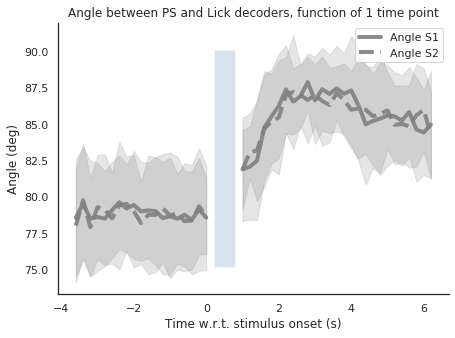

In [398]:
plt.rcParams['figure.figsize'] = (7, 5)
ax_acc = plt.subplot(111)


mouse_list = np.unique([ss.mouse for _, ss in sessions.items()])
region_list=['s1', 's2']
freq = 5
new_time = tp_dict['mutual']
# if 'pred_dec_test' in df_prediction_test[mouse_list[0]].columns:
# plot_interrupted_trace(ax=ax_acc
#                        , plot_array=lick_acc, bool_plot_std=False,
#                        llabel='decision', ccolor=(0.00784313725490196, 0.6196078431372549, 0.45098039215686275))
# # if 'pred_stim_test' in df_prediction_test[mouse_list[0]].columns:
# plot_interrupted_trace(ax=ax_acc, plot_array=ps_acc, llabel='ps', ccolor=(0.5803921568627451, 0.5803921568627451, 0.5803921568627451))

# plot_dict_split = ps_acc_split
# for iplot, key in enumerate(np.sort(np.array(list(plot_dict_split.keys())))):
#     dict_part = plot_dict_split[key]
#     plot_interrupted_trace(ax=ax_acc, plot_array=dict_part, llabel=str(key), 
#                            ccolor=color_dict_stand[iplot], plot_indiv=True)

plot_interrupted_trace(ax=ax_acc, time_array=new_time, plot_array=angle_dec, llabel='Angle',
                       plot_errorbar=False, plot_indiv=False, plot_std_area=True)

# plot_interrupted_trace(ax=ax_acc, plot_array=lick_half, bool_plot_std=False, llabel='0.5')
ax_acc.set_xlabel('Time w.r.t. stimulus onset (s)'); ax_acc.set_ylabel('Angle (deg)')
ax_acc.legend(); ax_acc.set_title('Angle between PS and Lick decoders, function of 1 time point');
# plt.xlim([180, 220])
sns.despine()

In [376]:
tp_list = [-0.2, 1.0, 3.8]
dict_df_test = {reg: {} for reg in region_list}
for reg in region_list:
    for tp in tp_list:
        _, dict_df_test[reg][tp] = train_test_all_sessions(sessions=sessions, verbose=0,# n_split=n_split,
                                                      trial_times_use=np.array([tp]),
                                                 hitmiss_only=False,# list_test=['dec', 'stim'],
                                                 include_autoreward=True, neurons_selection=reg,
                                                 C_value=0.02, train_projected=True)


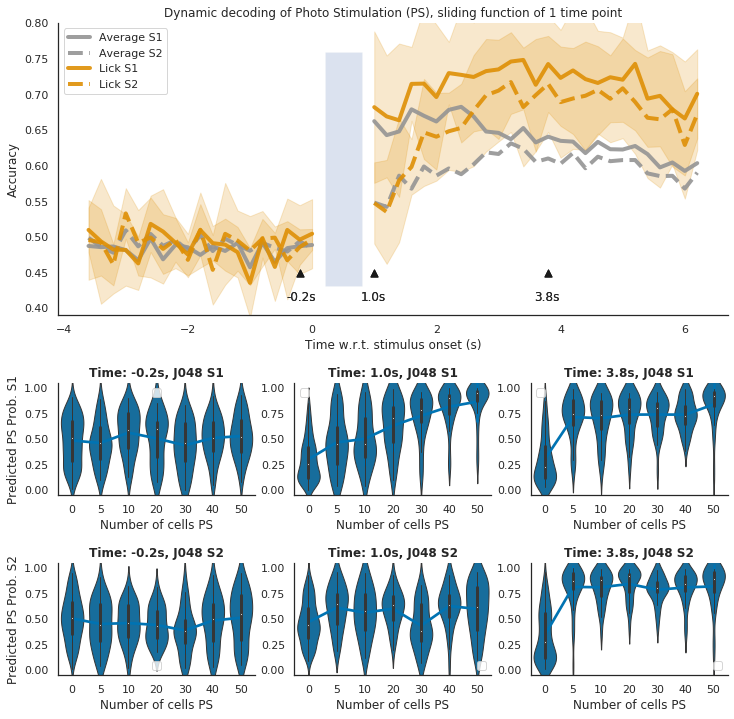

In [408]:
## Complete fig:

plt.rcParams['figure.figsize'] = (12, 12)
plt.subplots_adjust(wspace=0.2, hspace=0.6)
ax_acc = plt.subplot(4, 1, (1, 2))
plot_interrupted_trace(ax=ax_acc,  time_array=new_time, plot_array=ps_acc, plot_indiv=False,
                       llabel='Average', ccolor=(0.5803921568627451, 0.5803921568627451, 0.5803921568627451))

plot_dict_split = ps_acc_split
label_split = {0: 'No lick', 1: 'Lick'}
for iplot, key in enumerate(np.sort(np.array(list(plot_dict_split.keys())))):
    if iplot == 0:
        continue
    dict_part = plot_dict_split[key]
    plot_interrupted_trace(ax=ax_acc, time_array=new_time, plot_array=dict_part, llabel=label_split[key], 
                           ccolor=color_dict_stand[iplot], plot_indiv=False, plot_laser=False, 
                           plot_errorbar=False, plot_std_area=True)
#     if iplot == 0:
#         break

ax_acc.set_xlabel('Time w.r.t. stimulus onset (s)'); ax_acc.set_ylabel('Accuracy')
ax_acc.legend(loc='upper left'); ax_acc.set_title('Dynamic decoding of Photo Stimulation (PS), sliding function of 1 time point');
ax_acc.set_ylim([0.39, 0.8])
mouse = 'J048'
ax_tp = {}
for i_reg, reg in enumerate(region_list):
    for i_tp, tp in enumerate(tp_list):
        plt.subplot(4, 3, i_tp + 7 + (3 * i_reg))
        curr_df = dict_df_test[reg][tp][mouse]
        tmp = plot_df_stats(df=curr_df[curr_df['true_dec_test'] == 1], xx='true_stim_test', yy='pred_stim_test', hh='true_dec_test',
                            xticklabels=np.unique(dict_df_test[reg][tp][mouse]['true_stim_test']).astype('int'), 
                            type_scatter='violin', plot_line=True)  # set hh=None or hh='dec_test'
        plt.xlabel('Number of cells PS'); plt.title(f'Time: {tp}s, {mouse} {reg.upper()}', weight='bold'); plt.legend([])
        plt.ylim([-0.05, 1.05])
        ax_acc.scatter([tp], [.45], marker='^', s=50, color='k')
        ax_acc.text(s=f'{tp}s', x=tp - 0.22, y=0.41)
        if i_tp == 0:
             plt.ylabel(f'Predicted PS Prob. {reg.upper()}'); 
        else:
            plt.ylabel('')

sns.despine()

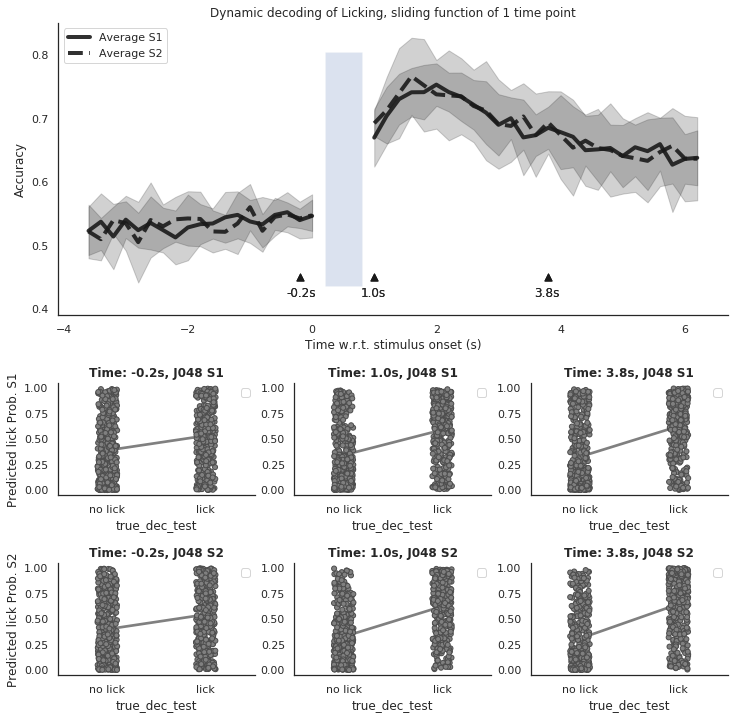

In [406]:
## Complete fig:

plt.rcParams['figure.figsize'] = (12, 12)
plt.subplots_adjust(wspace=0.2, hspace=0.6)
ax_acc = plt.subplot(4, 1, (1, 2))
plot_interrupted_trace(ax=ax_acc,  time_array=new_time,plot_array=lick_acc, 
                       llabel='Average', ccolor='k', plot_std_area=True, plot_indiv=False)

# plot_dict_split = ps_acc_split
# label_split = {0: 'No lick', 1: 'Lick'}
# for iplot, key in enumerate(np.sort(np.array(list(plot_dict_split.keys())))):
#     dict_part = plot_dict_split[key]
#     plot_interrupted_trace(ax=ax_acc, time_array=new_time, plot_array=dict_part, llabel=label_split[key], 
#                            ccolor=color_dict_stand[iplot], plot_indiv=True, plot_laser=False)

ax_acc.set_xlabel('Time w.r.t. stimulus onset (s)'); ax_acc.set_ylabel('Accuracy')
ax_acc.legend(loc='upper left'); ax_acc.set_title('Dynamic decoding of Licking, sliding function of 1 time point');
ax_acc.set_ylim([0.39, 0.85])
# reg = 's2'
mouse = 'J048'
ax_tp = {}
for i_reg, reg in enumerate(region_list):
    for i_tp, tp in enumerate(tp_list):
        plt.subplot(4, 3, i_tp + 7 + (3 * i_reg))
        plot_df_stats(df=dict_df_test[reg][tp][mouse], xx='true_dec_test', yy='pred_dec_test', hh=None,
                      xticklabels=['no lick', 'lick'], type_scatter='strip')  # set hh=None or hh='dec_test'
        plt.title(f'Time: {tp}s, {mouse} {reg.upper()}', weight='bold'); plt.legend([])
        plt.ylim([-0.05, 1.05])
        ax_acc.scatter([tp], [.45], marker='^', s=50, color='k')
        ax_acc.text(s=f'{tp}s', x=tp - 0.22, y=0.42)
        if i_tp == 0:
             plt.ylabel(f'Predicted lick Prob. {reg.upper()}'); 
        else:
            plt.ylabel('')

sns.despine()

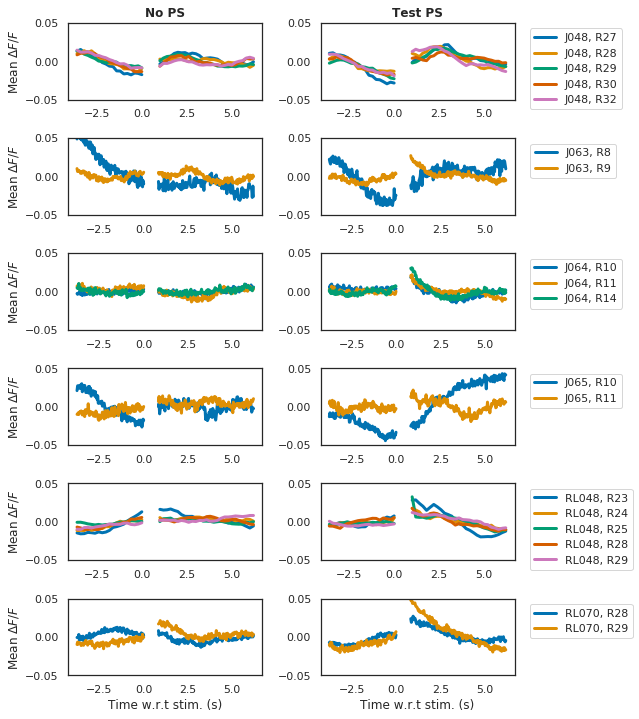

In [279]:
mouse_list = np.unique([ss.mouse for _, ss in sessions.items()])

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.rcParams['figure.figsize'] = (8, 12)
title_ps = {0: 'No PS', 1: 'Test PS', 2: '150 PS', 3: 'Run legend:'}
# mouse = mouse_list[5]
# mouse_list = mouse_list[:2]
av_axes = {}
i_ax = 0
range_ps = 2
color_index = {m: 0 for m in mouse_list}
legend_tuple = []
for i_m, mouse in enumerate(mouse_list):
    temp_session_list = [k for k, ss in sessions.items() if ss.mouse == mouse]
    for i_s in temp_session_list:
        ss = sessions[i_s]
        for i_ps in range(range_ps):
            av_axes[i_ax] = plt.subplot(len(mouse_list), range_ps, 1 + i_ps + range_ps * i_m)
            if i_ps <= 2:
                plot_interrupted_trace_simple(ax=av_axes[i_ax], time_array=ss.filter_ps_time,
                                              plot_array=np.mean(ss.behaviour_trials[:, ss.photostim == i_ps, :][:, :, ss.filter_ps_array], (0, 1)), 
                                              llabel=f'{mouse}, R{ss.run_number}', ccolor=color_dict_stand[color_index[mouse]], zero_mean=True)
            if i_ps <= 1:
                av_axes[i_ax].set_ylim([-0.05, 0.05])
            if i_m == 0:
                av_axes[i_ax].set_title(title_ps[i_ps], weight='bold')
            if i_m == len(mouse_list) - 1:
                av_axes[i_ax].set_xlabel('Time w.r.t stim. (s)')
            if i_ps == 0:
                av_axes[i_ax].set_ylabel('Mean ' + r'$\Delta F / F$')
            if i_ps == range_ps - 1 and i_s == temp_session_list[-1]:
                if mouse == 'J063':
                    leg = av_axes[i_ax].legend(bbox_to_anchor=(1.55, 1))  # no clue why this needed
                else:
                    leg = av_axes[i_ax].legend(bbox_to_anchor=(1.05, 1))
                legend_tuple.append(leg)
            i_ax += 1
        color_index[mouse] += 1
legend_tuple = tuple(legend_tuple)
plt.savefig('figures/average_all_sessions.pdf', bbox_extra_artists=legend_tuple, bbox_inches='tight')


In [241]:
for _, ss in sessions.items():
    print(ss)
kk = 0

Mouse RL070, run 28
Mouse RL070, run 29
Mouse J048, run 27
Mouse J048, run 28
Mouse J048, run 29
Mouse J048, run 30
Mouse J048, run 32
Mouse J064, run 10
Mouse J064, run 11
Mouse J064, run 14
Mouse J063, run 8
Mouse J063, run 9
Mouse RL048, run 23
Mouse RL048, run 24
Mouse RL048, run 25
Mouse RL048, run 28
Mouse RL048, run 29
Mouse J065, run 10
Mouse J065, run 11


In [262]:
## Plot overlay of means all frames & filtered frames. => manually assessed that the current frame
## filter is the minimal to filter the artefact in all sessions. But for all 5Hz but 1, it could be shorter.
## For 30Hz it can be shorter as well, probably some nice info directly post stim.

# ss = sessions[kk] 
# print(ss)
# plt.rcParams['figure.figsize'] = (9, 5)
# plt.plot(np.mean(ss.behaviour_trials[:, ss.photostim == 1, :], (0, 1)), '.-')
# plt.plot(ss.filter_ps_array, np.mean(ss.behaviour_trials[:, ss.photostim == 1, :][:, :, ss.filter_ps_array], (0, 1)), '.-')
# kk += 1

## Cross validate regularization value

Idea:
  - It depends on number of neurons. So either scale with n_neurons, but I'm not sure what scaling (e.g. linear) this is.. So instead we'll optimise per session. S1/S2 are about 50/50 so we'll ignore this (also because their perfomance varies)
  - Per session; evaluate 3 seconds post stim at 5Hz. Find the maximum test decoding accuracy (for both decoders). we'll take the corresponding C value.
  - Save in some file because this takes some time to run

In [128]:
df_prediction_train, df_prediction_test = train_test_all_sessions(sessions={0: sessions[2]}, trial_times_use=np.array([1.6]), 
                                                          verbose=0, hitmiss_only=False, include_150=False,
                                                          include_autoreward=True, C_value=0.002,
                                                          train_projected=False,
                                                          neurons_selection='s1')

In [341]:
## Integrate different imaging frequencies:
assert 'mutual' in tp_dict.keys()
tp_dict['cv_reg'] = tp_dict['mutual'][np.logical_and(tp_dict['mutual'] <= 3, tp_dict['mutual'] > 0)]  # Use all time points < 3 post stim
c_value_array = np.array([50, 20, 5, 2, 0.5, 0.2, 0.05, 0.02, 0.005, 0.002])  # list of C values, where 1/C is reg strength
max_acc_scores = {}
for key, ss in sessions.items():
    print(ss)
    ## First without reg:
    max_dec_values = np.zeros((len(c_value_array) + 1, 2))
    (lick_acc, lick_acc_split, ps_acc, ps_acc_split, lick_half, 
             angle_dec) = compute_accuracy_time_array(sessions={0: ss}, time_array=tp_dict['cv_reg'],
                                                      projected_data=False, reg_type='none', average_fun=class_av_mean_accuracy)
    max_lick_dec = np.max([np.max(reg_acc[:, 0]) for _, reg_acc in lick_acc.items()])
    max_ps_dec = np.max([np.max(reg_acc[:, 0]) for _, reg_acc in ps_acc.items()])
    max_dec_values[0, :] = max_lick_dec.copy(), max_ps_dec.copy()  
    ## Then with varying reg strengths:
    for i_c, c_value in enumerate(c_value_array):
        ## Compute results
        (lick_acc, lick_acc_split, ps_acc, ps_acc_split, lick_half, 
             angle_dec) = compute_accuracy_time_array(sessions={0: ss}, time_array=tp_dict['cv_reg'],
                                                      projected_data=False, regularizer=c_value,
                                                      average_fun=class_av_mean_accuracy)
        max_lick_dec = np.max([np.max(reg_acc[:, 0]) for _, reg_acc in lick_acc.items()])
        max_ps_dec = np.max([np.max(reg_acc[:, 0]) for _, reg_acc in ps_acc.items()])
        max_dec_values[i_c + 1, :] = max_lick_dec.copy(), max_ps_dec.copy()
    ## Save:
    max_acc_scores[key] = max_dec_values.copy()
    

0it [00:00, ?it/s]

Mouse RL070, run 28


11it [00:04,  2.52it/s]
11it [00:06,  1.63it/s]
11it [00:06,  1.63it/s]
11it [00:06,  1.66it/s]
11it [00:06,  1.72it/s]
11it [00:05,  1.87it/s]
11it [00:05,  2.04it/s]
11it [00:04,  2.36it/s]
11it [00:04,  2.56it/s]
11it [00:03,  2.81it/s]
11it [00:03,  2.89it/s]
0it [00:00, ?it/s]

Mouse RL070, run 29


11it [00:03,  3.01it/s]
11it [00:05,  2.01it/s]
11it [00:05,  2.03it/s]
11it [00:05,  2.04it/s]
11it [00:05,  2.02it/s]
11it [00:04,  2.20it/s]
11it [00:04,  2.34it/s]
11it [00:03,  2.76it/s]
11it [00:03,  2.86it/s]
11it [00:03,  3.22it/s]
11it [00:03,  3.29it/s]
0it [00:00, ?it/s]

Mouse J048, run 27


11it [00:02,  4.10it/s]
11it [00:03,  2.90it/s]
11it [00:04,  2.74it/s]
11it [00:03,  2.77it/s]
11it [00:03,  2.77it/s]
11it [00:03,  2.84it/s]
11it [00:03,  3.04it/s]
11it [00:03,  3.24it/s]
11it [00:03,  3.58it/s]
11it [00:02,  4.07it/s]
11it [00:02,  4.25it/s]
0it [00:00, ?it/s]

Mouse J048, run 28


11it [00:03,  3.66it/s]
11it [00:04,  2.58it/s]
11it [00:04,  2.57it/s]
11it [00:04,  2.55it/s]
11it [00:04,  2.56it/s]
11it [00:04,  2.55it/s]
11it [00:04,  2.67it/s]
11it [00:03,  2.89it/s]
11it [00:03,  3.14it/s]
11it [00:02,  3.67it/s]
11it [00:02,  3.91it/s]
0it [00:00, ?it/s]

Mouse J048, run 29


11it [00:03,  2.88it/s]
11it [00:06,  1.65it/s]
11it [00:06,  1.75it/s]
11it [00:06,  1.61it/s]
11it [00:06,  1.76it/s]
11it [00:05,  1.87it/s]
11it [00:05,  2.06it/s]
11it [00:04,  2.29it/s]
11it [00:04,  2.60it/s]
11it [00:04,  2.57it/s]
11it [00:03,  3.39it/s]
0it [00:00, ?it/s]

Mouse J048, run 30


11it [00:03,  3.03it/s]
11it [00:05,  2.01it/s]
11it [00:05,  1.92it/s]
11it [00:05,  1.91it/s]
11it [00:05,  2.09it/s]
11it [00:05,  2.07it/s]
11it [00:04,  2.26it/s]
11it [00:04,  2.58it/s]
11it [00:04,  2.72it/s]
11it [00:04,  2.69it/s]
11it [00:03,  3.46it/s]
0it [00:00, ?it/s]

Mouse J048, run 32


11it [00:03,  3.01it/s]
11it [00:05,  1.93it/s]
11it [00:05,  1.99it/s]
11it [00:05,  1.92it/s]
11it [00:05,  1.97it/s]
11it [00:05,  1.99it/s]
11it [00:05,  2.15it/s]
11it [00:04,  2.27it/s]
11it [00:04,  2.57it/s]
11it [00:03,  3.21it/s]
11it [00:03,  3.31it/s]
0it [00:00, ?it/s]

Mouse J064, run 10


11it [00:02,  4.41it/s]
11it [00:03,  3.03it/s]
11it [00:03,  2.98it/s]
11it [00:03,  3.03it/s]
11it [00:03,  3.04it/s]
11it [00:03,  3.30it/s]
11it [00:03,  3.65it/s]
11it [00:02,  4.18it/s]
11it [00:02,  4.60it/s]
11it [00:02,  5.01it/s]
11it [00:02,  5.03it/s]
0it [00:00, ?it/s]

Mouse J064, run 11


11it [00:02,  3.69it/s]
11it [00:04,  2.68it/s]
11it [00:04,  2.66it/s]
11it [00:04,  2.68it/s]
11it [00:04,  2.68it/s]
11it [00:03,  2.82it/s]
11it [00:03,  3.02it/s]
11it [00:03,  3.33it/s]
11it [00:03,  3.55it/s]
11it [00:02,  3.90it/s]
11it [00:02,  3.98it/s]
0it [00:00, ?it/s]

Mouse J064, run 14


11it [00:03,  2.82it/s]
11it [00:05,  2.00it/s]
11it [00:05,  1.98it/s]
11it [00:05,  2.00it/s]
11it [00:05,  2.04it/s]
11it [00:05,  2.12it/s]
11it [00:04,  2.25it/s]
11it [00:04,  2.54it/s]
11it [00:04,  2.74it/s]
11it [00:03,  2.97it/s]
11it [00:03,  3.06it/s]
1it [00:00,  6.29it/s]

Mouse J063, run 8


11it [00:01,  6.96it/s]
11it [00:02,  3.97it/s]
11it [00:02,  3.99it/s]
11it [00:02,  4.30it/s]
11it [00:02,  4.58it/s]
11it [00:01,  5.67it/s]
11it [00:01,  6.39it/s]
11it [00:01,  7.44it/s]
11it [00:01,  8.14it/s]
11it [00:01,  8.55it/s]
11it [00:01,  8.71it/s]
0it [00:00, ?it/s]

Mouse J063, run 9


11it [00:03,  3.33it/s]
11it [00:04,  2.43it/s]
11it [00:04,  2.44it/s]
11it [00:04,  2.44it/s]
11it [00:04,  2.51it/s]
11it [00:04,  2.62it/s]
11it [00:03,  2.78it/s]
11it [00:03,  3.12it/s]
11it [00:03,  3.30it/s]
11it [00:03,  3.62it/s]
11it [00:02,  3.67it/s]
0it [00:00, ?it/s]

Mouse RL048, run 23


11it [00:03,  2.98it/s]
11it [00:05,  2.11it/s]
11it [00:05,  2.07it/s]
11it [00:06,  1.81it/s]
11it [00:06,  1.57it/s]
11it [00:06,  1.60it/s]
11it [00:06,  1.79it/s]
11it [00:04,  2.35it/s]
11it [00:04,  2.57it/s]
11it [00:04,  2.50it/s]
11it [00:03,  2.79it/s]
0it [00:00, ?it/s]

Mouse RL048, run 24


11it [00:03,  2.76it/s]
11it [00:04,  2.21it/s]
11it [00:05,  2.07it/s]
11it [00:04,  2.20it/s]
11it [00:05,  2.04it/s]
11it [00:05,  2.18it/s]
11it [00:04,  2.36it/s]
11it [00:04,  2.60it/s]
11it [00:04,  2.68it/s]
11it [00:03,  2.90it/s]
11it [00:03,  3.11it/s]
0it [00:00, ?it/s]

Mouse RL048, run 25


11it [00:05,  1.95it/s]
11it [00:07,  1.38it/s]
11it [00:07,  1.40it/s]
11it [00:08,  1.36it/s]
11it [00:08,  1.30it/s]
11it [00:07,  1.45it/s]
11it [00:07,  1.51it/s]
11it [00:07,  1.53it/s]
11it [00:06,  1.64it/s]
11it [00:05,  1.90it/s]
11it [00:05,  2.02it/s]
0it [00:00, ?it/s]

Mouse RL048, run 28


11it [00:04,  2.29it/s]
11it [00:07,  1.47it/s]
11it [00:07,  1.48it/s]
11it [00:07,  1.50it/s]
11it [00:07,  1.49it/s]
11it [00:07,  1.40it/s]
11it [00:07,  1.55it/s]
11it [00:07,  1.48it/s]
11it [00:06,  1.66it/s]
11it [00:05,  1.95it/s]
11it [00:06,  1.82it/s]
0it [00:00, ?it/s]

Mouse RL048, run 29


11it [00:04,  2.53it/s]
11it [00:05,  2.02it/s]
11it [00:05,  2.05it/s]
11it [00:05,  1.93it/s]
11it [00:05,  1.88it/s]
11it [00:05,  1.92it/s]
11it [00:05,  1.94it/s]
11it [00:04,  2.25it/s]
11it [00:04,  2.45it/s]
11it [00:03,  2.99it/s]
11it [00:03,  3.26it/s]
0it [00:00, ?it/s]

Mouse J065, run 10


11it [00:01,  5.82it/s]
11it [00:03,  3.04it/s]
11it [00:03,  3.21it/s]
11it [00:02,  3.76it/s]
11it [00:02,  4.34it/s]
11it [00:01,  5.64it/s]
11it [00:01,  6.49it/s]
11it [00:01,  7.67it/s]
11it [00:01,  7.97it/s]
11it [00:01,  8.33it/s]
11it [00:01,  8.37it/s]
0it [00:00, ?it/s]

Mouse J065, run 11


11it [00:02,  4.65it/s]
11it [00:03,  3.03it/s]
11it [00:03,  3.12it/s]
11it [00:03,  3.17it/s]
11it [00:03,  3.30it/s]
11it [00:03,  3.50it/s]
11it [00:02,  3.85it/s]
11it [00:02,  4.39it/s]
11it [00:02,  4.65it/s]
11it [00:02,  5.00it/s]
11it [00:02,  5.07it/s]


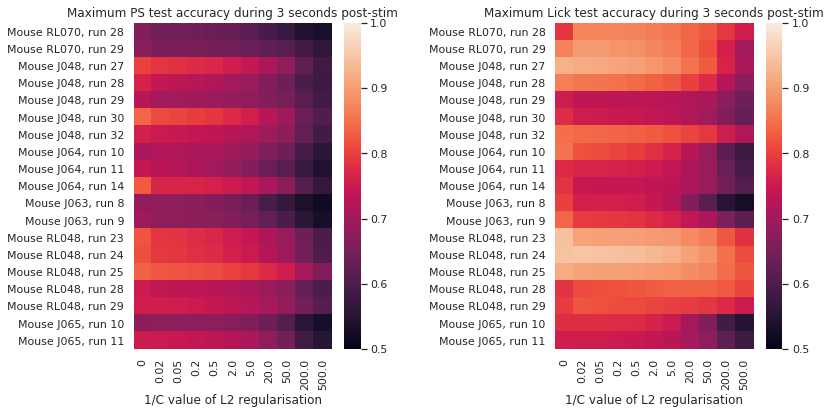

In [364]:
n_sessions = len(max_acc_scores)
n_cvalues = max_acc_scores[0].shape[0]
dict_max_acc_all = {xx: np.zeros((n_sessions, n_cvalues)) for xx in ['PS', 'Lick']}
for key, acc in max_acc_scores.items():
    dict_max_acc_all['Lick'][key, :] = acc[:, 0]
    dict_max_acc_all['PS'][key, :] = acc[:, 1]
    
c_labels = [0] + [1/c for c in c_value_array]
ss_labels = [str(ss) for key, ss in sessions.items()]
plt.rcParams['figure.figsize'] = (12, 6)
plt.subplots_adjust(wspace=0.7)
for i_plot, xx in enumerate(['PS', 'Lick']):
    plt.subplot(1, 2, i_plot + 1)
    ax1 = sns.heatmap(dict_max_acc_all[xx], xticklabels=c_labels, yticklabels=ss_labels, vmin=0.5, vmax=1)
    plt.xlabel('1/C value of L2 regularisation'); plt.title(f'Maximum {xx} test accuracy during 3 seconds post-stim')
    bottom, top = ax1.get_ylim()
    ax1.set_ylim(bottom + 0.5, top - 0.5)

plt.savefig('figures/optimise_regularisation.pdf', bbox_inches='tight')

In [371]:
def create_df_table_details(sessions):
    """Create Dataframe table with details of sessions."""
    n_sessions = len(sessions)
    column_names = ['Mouse', 'Run number', 'Frequency (Hz)', '# Imaging planes',
                    '# S1 neurons', '# S2 neurons',
                    '# trials', '# Hit', '# FA', '# Miss', '# CR']
    dict_details = {cc: np.zeros(n_sessions, dtype='object') for cc in column_names}
    for key, ss in sessions.items():
        dict_details['Mouse'][key] = ss.mouse
        dict_details['Run number'][key] = ss.run_number
        dict_details['Frequency (Hz)'][key] = ss.frequency
        dict_details['# Imaging planes'][key] = len(np.unique(ss.plane_number))
        dict_details['# S1 neurons'][key] = np.sum(ss.s1_bool)
        dict_details['# S2 neurons'][key] = np.sum(ss.s2_bool)
        dict_details['# trials'][key] = len(ss.outcome)
        dict_details['# Hit'][key] = np.sum(ss.outcome == 'hit')
        dict_details['# FA'][key] = np.sum(ss.outcome == 'fp')
        dict_details['# Miss'][key] = np.sum(ss.outcome == 'miss')
        dict_details['# CR'][key] = np.sum(ss.outcome == 'cr')
    df_details = pd.DataFrame(dict_details)
    df_details = df_details.sort_values(by=['Mouse', 'Run number'])
    df_details = df_details.reset_index()
    del df_details['index']
    return df_details

df_details = create_df_table_details(sessions=sessions)
df_details
# df_details.to_latex(index=False)  # print latex Tabular code

,Mouse,Run number,Frequency (Hz),# Imaging planes,# S1 neurons,# S2 neurons,# trials,# Hit,# FA,# Miss,# CR
0,J048,27,5,3,1015,1086,130,59,25,21,25
1,J048,28,5,3,1060,1134,160,70,17,37,36
2,J048,29,5,3,758,772,303,131,41,73,58
3,J048,30,5,3,966,1119,209,97,30,34,48
4,J048,32,5,3,1005,967,254,98,24,68,64
5,J063,8,30,1,77,83,114,42,10,33,29
6,J063,9,30,1,320,439,210,97,19,51,43
7,J064,10,30,1,251,225,163,80,28,22,33
8,J064,11,30,1,439,363,167,92,13,31,31
9,J064,14,30,1,522,459,209,113,25,36,35


## ideas to improve / directions to go

#### Current plot:

- Distribution weight matrix
- plot \Delta W(t, t-1)

#### Try to find a function of the data that enhances the readout.

- Dimensionality reduction (dPCA should be ideal, theoretically)


#### S1 / S2 comparison

- Add dynamic prediction between populations -> subspaces -> Same question as with semedo data (i.e. different neurons that predict S2 or decode stim)

- Use increasing/decreasing number of neurons